## The SIR model with two age groups

The partitioning of the population can be refined to include other attributes relevant to the disease. One of the most important of these is the age. Let us assume we partition the population into two age groups, children and adults, and label them by the index $i=1,2$. Children can catch the infection from other children or from adults; likewise, adults can catch the infection from other adults or from children. Calling their respective rates of infection $\lambda_1(t)$ and $\lambda_2(t)$ we get
\begin{align}
\lambda_1(t) = \beta(C_{11}\frac{I_1}{N_1} + C_{12}\frac{I_2}{N_2})S_1\\
\lambda_2(t) = \beta(C_{21}\frac{I_1}{N_1} + C_{22}\frac{I_2}{N_2})S_2
\end{align}
where $C_{ij}$ are contact matrices, quantifying how much each age group interacts with the other. The ordinary differential equations of this age-structured SIR model are 

\begin{align}
\dot S_i &= -\lambda_i(t)S_i \\
\dot I_i &= \lambda(t)_iI_i - \gamma I_i \\
\dot R_i &= \gamma I_i 
\end{align}

Again, for each $i$ the sum $N_i = S_i + I_i + R_i$ remains constant. What do we expect qualitatively ? The group that has a greater rate will catch the disease faster and catch more of it. This depends on how the entries of the contact matrix are distributed. 

This example creates stochastic trajectories for the above equations for both the children and the adults. We see that they have unequal rates of infection. 

In [2]:
%matplotlib inline
import numpy as np
import pyross
import matplotlib.pyplot as plt

In [3]:
M  = 2                  # the population has two age groups
N  =  100000           # and this is the total population

beta  = 0.0131          # infection rate
gIa   = 1./7            # removal rate of asymptomatic infectives 
gIs   = 1./7            # removal rate of asymptomatic infectives 
alpha = 0               # fraction of asymptomatic infectives 
fsa   = 1               # Fraction by which symptomatic individuals do not self isolate


Ni = np.zeros((M))      # population in each group
fi = np.zeros((M))      # fraction of population in age age group

# set the age structure
fi = np.array((0.25, 0.75)) 
for i in range(M):
    Ni[i] = fi[i]*N
    
# set the contact structure
C = np.array(([18., 9.], [3., 12.]))
    
    
Ia_0 = np.array((5,5))  # each age group has asymptomatic infectives
Is_0 = np.array((5,5))  # and also symptomatic infectives 
R_0  = np.array((0,0))  # there are no removed individuals initially
S_0  = Ni - (Ia_0 + Is_0 + R_0)

In [4]:
# duration of simulation and data file
Tf=200; Nf=Tf+1

# the contact structure is independent of time 
def contactMatrix(t):
    return C

# instantiate model
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
model = pyross.stochastic.SIR(parameters, M, Ni)


# simulate model
data=model.simulate(S_0, Ia_0, Is_0, contactMatrix, Tf, Nf)

In [5]:
IK = data.get('X')[:,2*M].flatten()
IA = data.get('X')[:,2*M+1].flatten()
t  = data.get('t') 

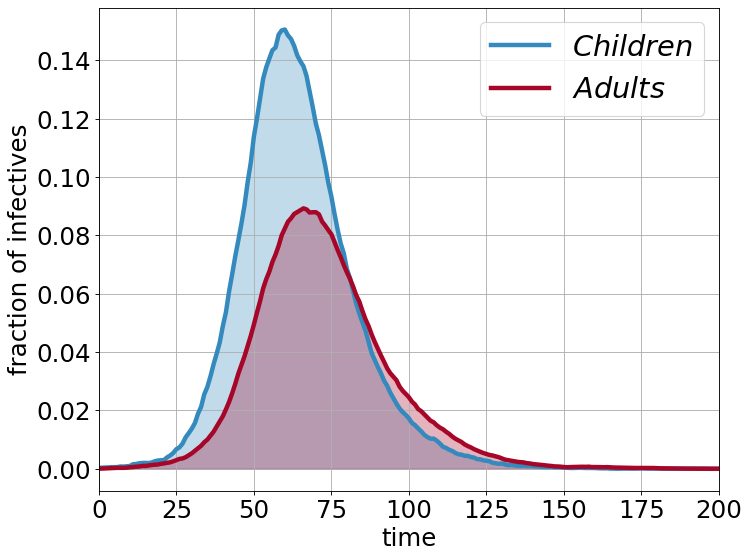

In [6]:
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})


plt.fill_between(t, 0, IK/Ni[0], color="#348ABD", alpha=0.3)
plt.plot(t, IK/Ni[0], '-', color="#348ABD", label='$Children$', lw=4)

plt.fill_between(t, 0, IA/Ni[1], color='#A60628', alpha=0.3)
plt.plot(t, IA/Ni[1], '-', color='#A60628', label='$Adults$', lw=4)

plt.legend(fontsize=26); plt.grid() 
plt.xlabel(r'time') ; plt.ylabel(r'fraction of infectives')
plt.autoscale(enable=True, axis='x', tight=True)

In [7]:
# run 100 simulations, calculate mean and standard deviation

N_runs = 100
trajectories_s = np.zeros([N_runs,Nf,3*len(S_0)],dtype=float)
for i in range(N_runs):
    print('Running simulation {0} of {1}'.format(i+1,N_runs),end='\r')
    cur_result = model.simulate(S_0, Ia_0, Is_0, contactMatrix, Tf, Nf,
                               method='tau-leaping') 
    trajectories_s[i] = cur_result['X']
t_s = cur_result['t']
mean_s = np.mean(trajectories_s,axis=0)
std_s = np.std(trajectories_s,axis=0)

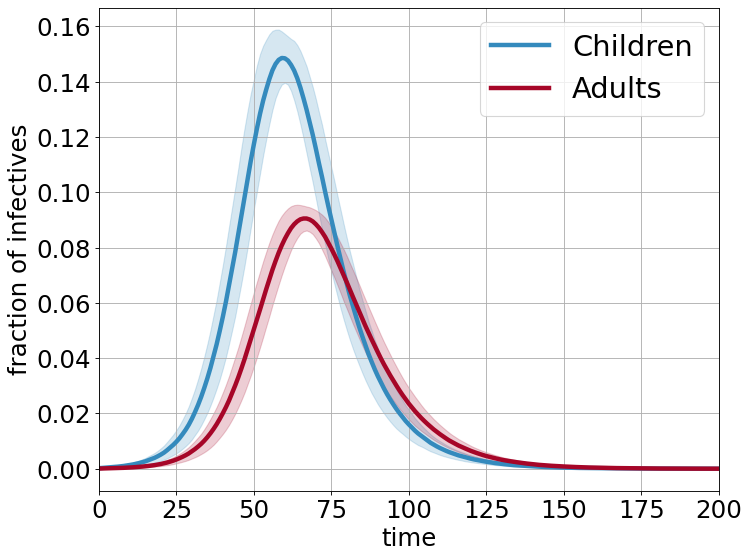

In [8]:
# plot mean and standard deviation

# Children
S_s  = mean_s[:,0].flatten()
Ia_s = mean_s[:,M].flatten()
Is_s = mean_s[:,2*M].flatten()
dS_s = std_s[:,0].flatten()
dIa_s = std_s[:,M].flatten()
dIs_s = std_s[:,2*M].flatten()
# for the removed, we still need to calculate mean and variance
R_s_trajectories = Ni[0] - trajectories_s[:,:,0] - trajectories_s[:,:,M] - trajectories_s[:,:,2*M]
R_s = np.mean(R_s_trajectories,axis=0)
dR_s = np.std(R_s_trajectories,axis=0)


# Adults
S_s_  = mean_s[:,1].flatten()
Ia_s_ = mean_s[:,M+1].flatten()
Is_s_ = mean_s[:,2*M+1].flatten()
dS_s_ = std_s[:,1].flatten()
dIa_s_ = std_s[:,M+1].flatten()
dIs_s_ = std_s[:,2*M+1].flatten()
# for the removed, we still need to calculate mean and variance
R_s_trajectories_ = Ni[1] - trajectories_s[:,:,1] - trajectories_s[:,:,1+M] - trajectories_s[:,:,1+2*M]
R_s_ = np.mean(R_s_trajectories,axis=0)
dR_s_ = np.std(R_s_trajectories,axis=0)




fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})

# children
#plt.fill_between(t_s,(S_s - dS_s)/Ni[0],(S_s + dS_s)/Ni[0],color="#348ABD", alpha=0.2)
#plt.plot(t_s, S_s/Ni[0], '-', color="#348ABD", label=r'$\langle S\rangle$', lw=4)
plt.fill_between(t_s,(Is_s - dIs_s)/Ni[0],(Is_s + dIs_s)/Ni[0],color="#348ABD", alpha=0.2)
plt.plot(t_s, Is_s/Ni[0], '-', color="#348ABD", label=r'Children', lw=4)
#plt.fill_between(t_s,(R_s - dR_s)/Ni[0],(R_s + dR_s)/Ni[0],color="dimgrey", alpha=0.2)
#plt.plot(t_s, R_s/Ni[0], '-', color="dimgrey", label=r'$\langle R\rangle $', lw=4)

# adults
plt.fill_between(t_s,(Is_s_ - dIs_s_)/Ni[1],(Is_s_ + dIs_s_)/Ni[1],color="#A60628", alpha=0.2)
plt.plot(t_s, Is_s_/Ni[1], '-', color="#A60628", label=r'Adults', lw=4)



plt.legend(fontsize=26,loc='upper right'); plt.grid() 
plt.xlabel(r'time') ; plt.ylabel(r'fraction of infectives')
plt.autoscale(enable=True, axis='x', tight=True)